In [206]:
import pandas as pd
import networkx as nx
import collections
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os
import json
import sys
import sqlite3

Library versions:

In [44]:
nx.__version__

'2.5'

In [45]:
pd.__version__

'1.2.3'

In [46]:
matplotlib.__version__

'3.1.1'

# Data loading

In [47]:
listenings = pd.read_csv('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',
                         sep='\t',error_bad_lines=False, header= None,
                         names=['userid','timestamp','artid','artname','traid','traname'])

In [48]:
# convert timestamp's datatype and use it as index
listenings['timestamp'] = pd.to_datetime(listenings['timestamp'])
listenings.index = listenings['timestamp']

In [49]:
listenings.head()

,userid,timestamp,artid,artname,traid,traname
timestamp,,,,,,
2009-05-04 23:08:57+00:00,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
2009-05-04 13:54:10+00:00,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2009-05-04 13:52:04+00:00,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
2009-05-04 13:42:52+00:00,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
2009-05-04 13:42:11+00:00,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [50]:
listenings.tail()

,userid,timestamp,artid,artname,traid,traname
timestamp,,,,,,
2008-01-27 22:02:35+00:00,user_001000,2008-01-27 22:02:35+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,a490cabc-1e5c-4807-86c7-740c31a50009,Please Be Patient With Me
2008-01-27 21:56:52+00:00,user_001000,2008-01-27 21:56:52+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3e92e447-9e1f-440d-bc00-6734469880c5,Shake It Off
2008-01-27 21:52:36+00:00,user_001000,2008-01-27 21:52:36+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,93d044e6-1bbb-46a6-ac8e-283382a89e6f,Side With The Seeds
2008-01-27 21:49:12+00:00,user_001000,2008-01-27 21:49:12+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,5ac4386f-6146-4389-a762-4b43f362d2c8,Sky Blue Sky
2008-01-27 21:43:14+00:00,user_001000,2008-01-27 21:43:14+00:00,9e53f84d-ef44-4c16-9677-5fd4d78cbd7d,Wilco,3acc99bc-a349-420f-ad28-7095eb3533c9,Impossible Germany


# Check for possible anomalies in the data

In [51]:
listenings.shape

(19098862, 6)

In [52]:
# number of null values
listenings.isnull().sum()

userid             0
timestamp          0
artid         600853
artname            0
traid        2162726
traname           12
dtype: int64

In [53]:
# drop the few rows where track name is missing - these would be useless for future analysis
listenings.dropna(subset=['traname'],inplace=True)

In [97]:
# number of distinct users
listenings['userid'].nunique()

991

In [98]:
# number of distinct songs
listenings['traname'].nunique()

1075618

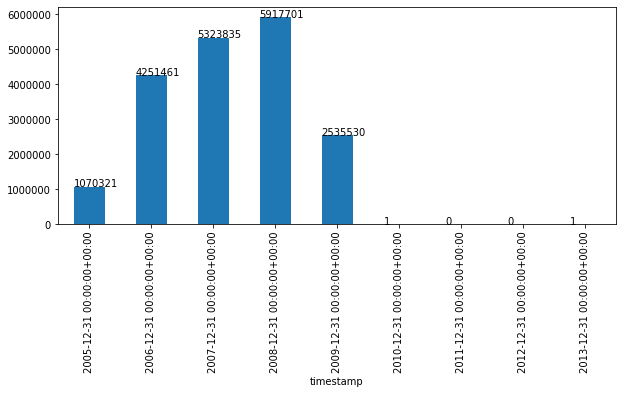

In [66]:

ax = listenings.resample('Y')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(10,4), title='Number of samples per year')

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))

In [70]:
# we remove the records in 2010 and 2013 which are obviously errors
listenings = listenings[listenings['timestamp'].dt.year<2010]

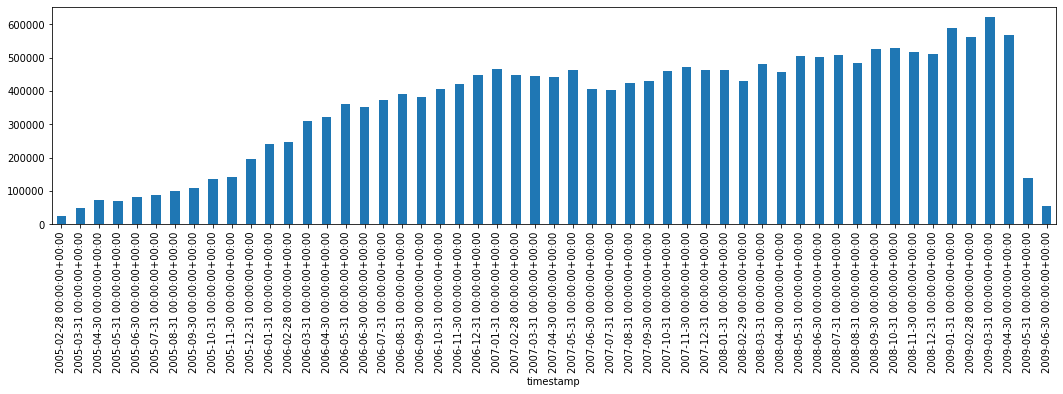

In [73]:
listenings.resample('M')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='Number of samples monthly')

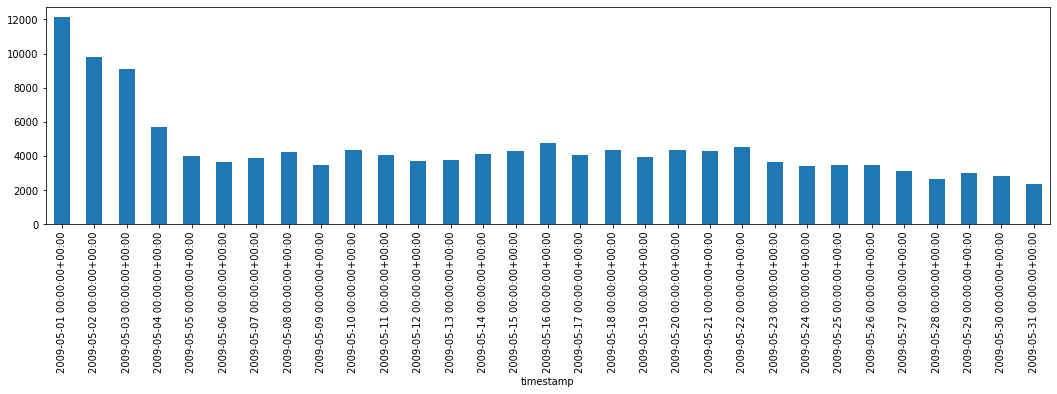

In [77]:
listenings[(listenings['timestamp'].dt.year==2009) & (listenings['timestamp'].dt.month==5)]\
    .resample('d')[['userid']].count()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='May 2009 daily count of samples')

Despite the documentation saying the latest data point in the dataset should be from May 5th the data continues a bit further. The problem is there are a lot less samples for this time period when check the monthly counts so we rather remove both May and June 2009.

In [79]:
listenings = listenings[~((listenings['timestamp'].dt.year==2009) & (listenings['timestamp'].dt.month.isin((5,6))))]

In [95]:
# number of distinct users
listenings['userid'].nunique()

991

In [96]:
# number of distinct songs
listenings['traname'].nunique()

1075618

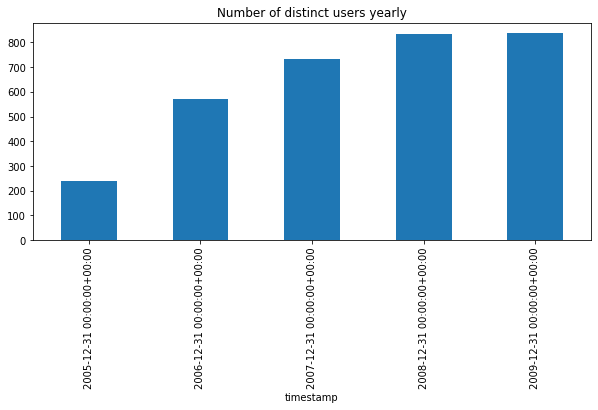

In [92]:
listenings.resample('Y').userid.nunique()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(10,4), title='Number of distinct users yearly')

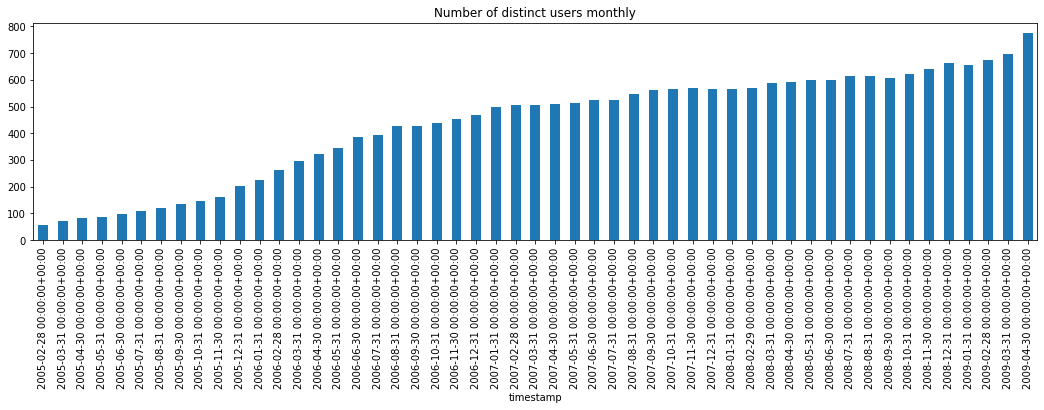

In [91]:
listenings.resample('M').userid.nunique()\
    .plot.bar(y='userid',use_index=True,legend=False,figsize=(18,4), title='Number of distinct users monthly')

In [ ]:
# TODO: solution

# Join with other datasets

## userid-profile.tsv

In [105]:
users = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv',sep='\t')
users.rename({'#id':'userid'},axis=1,inplace=True)
users.head()

,userid,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [111]:
users.shape

(992, 5)

In [106]:
# check if id attribute is unique
users['userid'].is_unique

True

Users data can be perfectly joined to the listenings data:

In [109]:
listenings.merge(users).shape

(18904597, 10)

In [108]:
listenings.shape

(18904597, 6)

Age has too many null values, only gender and country will be usable:

In [110]:
# number of null values
users.isnull().sum()

userid          0
gender        108
age           706
country        85
registered      8
dtype: int64

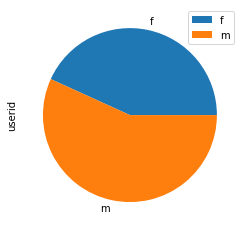

In [123]:
users.groupby('gender').count()[['userid']].plot.pie(y='userid')

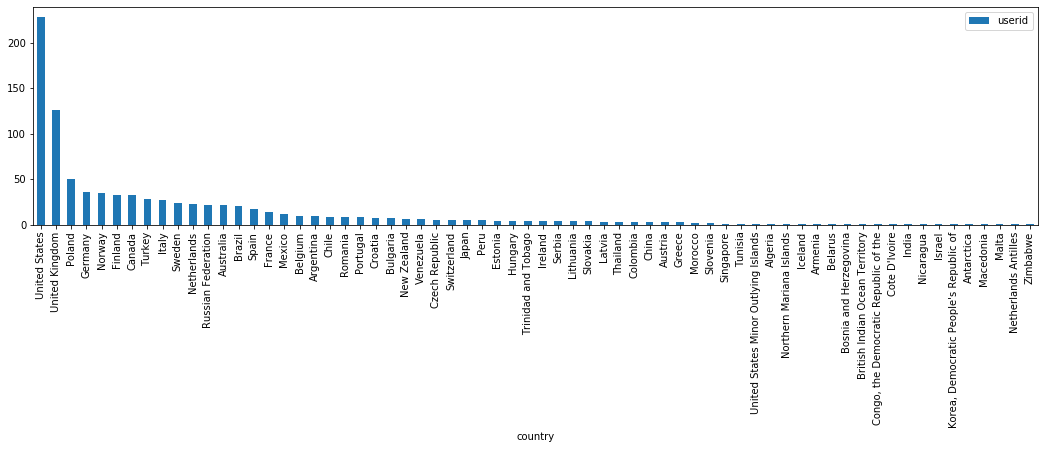

In [125]:
users.groupby('country').count()[['userid']].sort_values('userid',ascending=False)\
    .plot.bar(y='userid',figsize=(18,4))

## Million Song Dataset

In [154]:
dbfile = 'lastfm_tags.db'

# open connection
conn = sqlite3.connect(dbfile)

The database contains the following 3 tables:

In [203]:
pd.read_sql_query("""select * from tags LIMIT 3;""", conn)

,tag
0,classic rock
1,Progressive rock
2,blues


In [204]:
pd.read_sql_query("""select * from tids LIMIT 3;""", conn)

,tid
0,TRCCCYE12903CFF0E9
1,TRCCCFH12903CEBC70
2,TRCCCJT128F429FFF6


In [205]:
pd.read_sql_query("""select * from tid_tag LIMIT 3;""", conn)

,tid,tag,val
0,1,1,100.0
1,1,2,100.0
2,2,3,100.0


In [169]:
tags = pd.read_sql_query("""SELECT tags.tag, COUNT(tid_tag.tid) 
                        FROM tid_tag, tags 
                        WHERE tid_tag.tag=tags.ROWID 
                        GROUP BY tags.tag;""", conn)
topTags = tags.sort_values('COUNT(tid_tag.tid)',ascending=False)[:10]
topTags

,tag,COUNT(tid_tag.tid)
419585,rock,101071
397948,pop,69159
153075,alternative,55777
299442,indie,48175
233524,electronic,46270
248252,female vocalists,42565
245839,favorites,39921
80295,Love,34901
211486,dance,33618
919,00s,31432


In [173]:
topTagsStr = str(tuple(topTags['tag'][:5]))

In [196]:
trackGenres = pd.read_sql_query(f"""SELECT tids.tid,tags.tag,tid_tag.val, 
                                           ROW_NUMBER () OVER (PARTITION BY tids.tid ORDER BY val DESC) rn
                                     FROM tid_tag 
                                     JOIN tids ON tid_tag.tid=tids.ROWID
                                     JOIN tags ON tags.ROWID=tid_tag.tag
                                     WHERE tags.tag IN {topTagsStr};""", conn)

In [199]:
# get only the genre with highest val for each track
trackGenres = trackGenres[trackGenres['rn']==1]

In [202]:
trackGenres

,tid,tag,val,rn
0,TRAAAAK128F9318786,rock,60.0,1
1,TRAAABD128F429CF47,pop,41.0,1
3,TRAAADJ128F4287B47,rock,100.0,1
4,TRAAAED128E0783FAB,pop,17.0,1
6,TRAAAGR128F425B14B,pop,82.0,1
...,...,...,...,...
320443,TRZZZYG128F92EF836,pop,10.0,1
320445,TRZZZYR128F92F0796,rock,100.0,1
320449,TRZZZYV128F92E996D,pop,44.0,1
320450,TRZZZYX128F92D32C6,rock,33.0,1


In [211]:
listenings.head()

,userid,timestamp,artid,artname,traid,traname
timestamp,,,,,,
2009-04-30 17:42:39+00:00,user_000001,2009-04-30 17:42:39+00:00,3d05eb8b-1644-4143-9a61-b28e33c4d85f,4Hero,7ab86d3d-5ff6-4d04-b753-32ac3f30ff3d,Dedication To The Horse
2009-04-30 17:38:29+00:00,user_000001,2009-04-30 17:38:29+00:00,3d05eb8b-1644-4143-9a61-b28e33c4d85f,4Hero,96602c7b-c0e1-41a5-872d-39de2cc62a2c,Our Own Place
2009-04-30 17:35:44+00:00,user_000001,2009-04-30 17:35:44+00:00,3d05eb8b-1644-4143-9a61-b28e33c4d85f,4Hero,NaN,Gonna Give It Up
2009-04-30 17:31:38+00:00,user_000001,2009-04-30 17:31:38+00:00,3d05eb8b-1644-4143-9a61-b28e33c4d85f,4Hero,afc94794-ba9f-42d3-afea-9c55f153e224,Bed Of Roses
2009-04-30 17:27:02+00:00,user_000001,2009-04-30 17:27:02+00:00,3d05eb8b-1644-4143-9a61-b28e33c4d85f,4Hero,5c84c4fa-fbb3-4a05-a8bb-eef8b44b1f44,Why Don'T You Talk?


# Create graph structure

In [27]:
G = nx.MultiGraph()
G.add_nodes_from(listenings['userid'], isSong=False)
G.add_nodes_from(listenings['traname'], isSong=True)
G.add_edges_from(list(zip(listenings['userid'],listenings['traname'])),time = listenings['timestamp'])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 1,
 2,
 3,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 4,
 4,
 4,
 5,
 2,
 2,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 3,
 3,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 4,
 4,
 4,
 5,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 5,
 5,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 5,
 6,
 5,
 6,
 6,
 6,
 7,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 8,
 1,
 7,
 7,
 7,
 9,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 3,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,


# Degree distributions

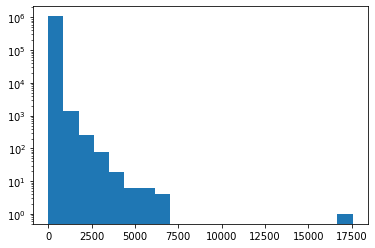

In [41]:
# log scaled degree distribution for songs 

songDegrees = [G.degree(n) for n,data in G.nodes(data=True) if data['isSong']==True]
plt.hist(songDegrees, bins=20)
plt.yscale('log', nonposy='clip')
plt.show()

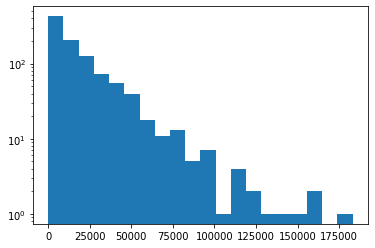

In [42]:
# log scaled degree distribution for users 

userDegrees = [G.degree(n) for n,data in G.nodes(data=True) if data['isSong']==False]
plt.hist(userDegrees, bins=20)
plt.yscale('log', nonposy='clip')
plt.show()